This code was written on/around 5/23/23 to analyze the data from the Ni15Cr stepped heating

In [1]:
import os.path
from os import listdir, chdir
from os.path import isfile, join, getmtime, split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, FastICA, NMF
import pandas as pd
from scipy.interpolate import make_interp_spline, splrep, BSpline
import scipy.signal
from tifffile import imsave

This notebook is for performing PCA analysis on XPS spectra.  This was implimented for the Ni15Cr native oxide heating data taken at various temperatures with good signal/noise ratio and varied angles.  

In [2]:

#They types of scans are preset here
elements = {'Transition':['Ni2p3/2', 'Cr2p3/2', 'Mo3d', 'O1s', 'C1s'],
            'Minimum BE':[849, 570, 222,525,278],
            'Maximum BE':[866,582,242,538,290]
            }
element_transitions = pd.DataFrame(elements)

"""These functions are all utilities!"""

def shift_spectra(xy, shift, manualinput=False):
    """shifts a spectra by amount shift.  Takes an array of x,y in either [2, x] or [x, 2]"""

    inputshape = xy.shape
    if inputshape[1] != 2 and inputshape[0] == 2:
        xy = np.transpose(xy)
        print("shift_spectra() transposed the x,y data")
    if manualinput:
        shift = float(input("Energy Shift: "))


    xy[:,0] = xy[:,0] + shift

    return xy

def EI_data_from_snapshot(linedata, kinetictobinding=True):
    """This block of code gets rid of the metadata starting with #, and sums up all of the individual measurements from
    each snapshot, and gets (energy, intensity) data in the numpy array 'dataset'"""

    str_dataset = []
    dataset = []  # this becomes your full dataset by the end, in python list format

    for row in linedata:
        if row.find('#') == -1:
            row_split = row.split()

            new_row = []
            row_str = ''  # accumulators
            intensity_sum = 0

            for element in row_split:
                try:
                    num_element = float(element)
                    if row_split.index(element) == 0:
                        if kinetictobinding:
                            new_row.append(1486.7-num_element)
                            row_str += element + '\t'
                        else:
                            new_row.append(num_element)
                            row_str += element + '\t'
                    else:
                        intensity_sum += num_element
                except:
                    pass
            row_str += str(intensity_sum) + '\n'
            str_dataset.append(row_str)
            new_row.append(intensity_sum)
            dataset.append(new_row)

    data = np.array(dataset)  # converts the data to a numpy array
    return data

def remove_outliers(edgesize, sigma, data):
    """Removes outliers by excluding the edge channels (defined by edgesize) and excluding anything with a value or
    derivative that is sigma standard deviations away from the mean"""
    diffdata = np.gradient(data[:, 1])
    averagediff = np.average(diffdata)
    stddiff = np.std(diffdata)
    outlierlist = []
    averagintensity = np.average(data[:, 1])
    stdintensity = np.std(data[:, 1])

    for i in range(len(diffdata)):
        if (abs(diffdata[i] - averagediff) > sigma * stddiff):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        elif (abs(data[i, 1] - averagintensity) > sigma * stdintensity):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        if ((i <= (edgesize-1)) and len(diffdata) >= edgesize):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
        elif ((len(diffdata) - i) <= edgesize):
            outlierlist = np.append(outlierlist, int(i))
            data[i,1] = np.NaN
    return data

def gather_snapshots(transition, masterdata,normalize=False):
    """
    Given a transition name (string) and a dataframe containing arrays of data corresponding to a transition, return
    a triangular set of coordinates with format (
    :param transition:
    :param masterdata:
    :return: plotdata
    """
    sorted_data = masterdata[masterdata.scantype == transition]
    plotdata = np.zeros((0,3))
    for j, i in enumerate(sorted_data.data):
        snapshot = (np.array(i))

        if normalize:
            snapshot = xps_reference.normalize_to_one(snapshot)
        indexs = np.zeros((snapshot.shape[0],1))
        indexs[:] = j
        snapshot = np.hstack((indexs,snapshot))
        plotdata = np.vstack((plotdata,snapshot))

    return plotdata

def plot_all_spectra(dataframe):
    """plots all the spectra in the data column of a dataframe taken from the snapshots_from_dir function"""
    for j, i in enumerate(dataframe.data):
        snapshot = (np.array(i))
        intensities = snapshot[:,1]
        plt.plot(intensities)
    plt.show()
    return

#this function is unfinished, working with objects in dataframes is hard and doesn't work sometimes
# def trim_all_spectra(dataframe,trim = 0):

#     for j, i in enumerate(dataframe.data):
#         print(j)
#         snapshot = (np.array(i))
#         #print(snapshot.shape)
#         dataframe.loc[j,"data"] = snapshot[trim:,:]
#     return dataframe


def normalize_group(masterlist):
    """Takes the master list and normalizes the spectra in the master list"""

    for i, name in enumerate(masterlist.index):
        rollingsum = 0
        snapshot = masterlist.iloc[i]
        if snapshot.scantype == "Ni2p3/2":
            j = i+1
            rollingsum +=snapshot.scansum
            scanlist = []
            scanlist = scanlist.append(snapshot.scantype)
            while ("Ni2p3/2" not in scanlist) and ("Mo3d" not in scanlist) and ("Cr2p3/2" not in scanlist):
                current = masterlist.iloc[j]
                if "O1s" in current.scantype:
                    j += 1
                    continue
                elif current.scantype in scanlist:
                    j +=1
                    continue
                rollingsum += current.scansum
                j+=1

            #print(rollingsum)
            rollingsum=0

    return masterlist

#These imports are for the shirley_calculate function
from numpy import array, linspace, arange, zeros, ceil, amax, amin, argmax, argmin, abs
from numpy.linalg import norm
def shirley_calculate(x, y, tol=1e-5, maxit=10):
    """ S = specs.shirley_calculate(x,y, tol=1e-5, maxit=10)
    Calculate the best auto-Shirley background S for a dataset (x,y). Finds the biggest peak
    and then uses the minimum value either side of this peak as the terminal points of the
    Shirley background.
    The tolerance sets the convergence criterion, maxit sets the maximum number
    of iterations.

    This function is from Kane O'Donnell
    https://github.com/kaneod/physics/blob/master/python/specs.py
    """

    DEBUG = False
    OPTION = 2

    # Make sure we've been passed arrays and not lists.
    x = array(x)
    y = array(y)

    # Sanity check: Do we actually have data to process here?
    if not (x.any() and y.any()):
        print("specs.shirley_calculate: One of the arrays x or y is empty. Returning zero background.")
        return zeros(x.shape)

    # Next ensure the energy values are *decreasing* in the array,
    # if not, reverse them.
    if x[0] < x[-1]:
        is_reversed = True
        x = x[::-1]
        y = y[::-1]
        print("shirley_calculate reversed the energy values")
    else:
        is_reversed = False

    # Locate the biggest peak.
    maxidx = abs(y - amax(y)).argmin()

    # It's possible that maxidx will be 0 or -1. If that is the case,
    # we can't use this algorithm, we return a zero background.
    if maxidx == 0 or maxidx >= len(y) - 1:
        print("specs.shirley_calculate: Boundaries too high for algorithm: returning a zero background.")
        return zeros(x.shape)

    # Locate the minima either side of maxidx.
    lmidx = abs(y[0:maxidx] - amin(y[0:maxidx])).argmin()
    rmidx = abs(y[maxidx:] - amin(y[maxidx:])).argmin() + maxidx
    xl = x[lmidx]
    yl = y[lmidx]
    xr = x[rmidx]
    yr = y[rmidx]

    # Max integration index
    imax = rmidx - 1

    # Initial value of the background shape B. The total background S = yr + B,
    # and B is equal to (yl - yr) below lmidx and initially zero above.
    B = zeros(x.shape)
    B[:lmidx] = yl - yr
    Bnew = B.copy()

    it = 0
    while it < maxit:
        if DEBUG:
            print("Shirley iteration: ", it)
        # Calculate new k = (yl - yr) / (int_(xl)^(xr) J(x') - yr - B(x') dx')
        ksum = 0.0
        for i in range(lmidx, imax):
            ksum += (x[i] - x[i + 1]) * 0.5 * (y[i] + y[i + 1]
                                               - 2 * yr - B[i] - B[i + 1])
        k = (yl - yr) / ksum
        # Calculate new B
        for i in range(lmidx, rmidx):
            ysum = 0.0
            for j in range(i, imax):
                ysum += (x[j] - x[j + 1]) * 0.5 * (y[j] +
                                                   y[j + 1] - 2 * yr - B[j] - B[j + 1])
            Bnew[i] = k * ysum
        # If Bnew is close to B, exit.
        if norm(Bnew - B) < tol:
            B = Bnew.copy()
            break
        else:
            B = Bnew.copy()
        it += 1

    if it >= maxit:
        print("specs.shirley_calculate: Max iterations exceeded before convergence.")
    if is_reversed:
        return (yr + B)[::-1]
    else:
        return yr + B

In [3]:
"""This is the main function for collecting all the snapshots in a directory and putting them in a dataframe"""

def snapshots_from_dir(search_dir, align_snapshots=False,subtract_shirley=False):
    """This function gathers the snapshots from each file and aligns them based off of the nickel peak"""
    # sort the snapshot files by the snapshot number- sorting by date doesn't work because they were all created by the exporter around the same time
    files = [f for f in listdir(search_dir) if (isfile(join(search_dir, f)) and "DS_Store" not in f)]
    files.sort(key=lambda x: x.split('-')[5])
    files.sort(key=lambda x: len(x))
    files = [os.path.join(search_dir, f) for f in files] # add path to each file

    masterlist = pd.DataFrame(columns=['filename','data','scantype', 'date','time','scansum'])
    shift = 0
    signalsum = 0
    for i, name in enumerate(files):
        #This loop gathers all the data and aligns the spectra
        if not (".txt" in name):
            continue
        elif ('._' in name):
            continue
        filepath = os.path.join(search_dir, name)
        f = open(filepath)
        lines = f.readlines()
        f.close()

        line1 = lines[0].split(" ")     #get the xps transition type from the metadata
        transition = line1[-2]+ line1[-1]
        transition = transition.replace("\n","")
        pair = os.path.split(name)
        tail = pair[1]
        filedate = tail.split('-')[0]
        filetime = tail.split('-')[1]
        filetime = filetime.split('_')[0]
        data = EI_data_from_snapshot(lines)

        #optional outlier removal
        #data = remove_outliers(3, 3)

        
        if align_snapshots:

            """Do the shift based on the valence band intersection with zero"""
            if "Valence" in transition:
                derivatives = np.gradient(data[:,1])

                #smooth the derivative using a b spline
                flipped_derivatives = np.flip(derivatives)
                flipped_x = np.flip(data[:, 0])
                spline_derivative = splrep(flipped_x, flipped_derivatives, s=10000)
                smoothed_derivative = BSpline(*spline_derivative)(flipped_x)
                valence_edge = (flipped_x[np.argmin(smoothed_derivative)])

                #plt.plot(np.flip(data[:, 0]), BSpline(*spline_derivative)(flipped_x))
                # plt.plot(data[:,0], derivatives)
                # plt.show()
                # #Optionally just use the minimum of the derivative
                # valence_edge = (data[np.argmin(derivatives),0])
                # print(valence_edge)
                shift = 0-valence_edge

            print(shift)    
            data = shift_spectra(data, shift)
        
        if subtract_shirley:
            shirleybr = shirley_calculate(data[:,0],data[:,1])
            data[:,1] = data[:,1]-shirleybr


        masterlist = masterlist.append([{'filename': name,
                                         'data': data,
                                         'scantype': transition,
                                         'date': filedate,
                                         'time': filetime,
                                         'center': shift,
                                         'scansum': np.sum(data[:,1])
                                         }])

    masterlist = masterlist.reset_index(drop=True)


    return masterlist

In [4]:
def perform_pca_1D(dataframe,energy_range=[0,1],mean_centered=False, trim_points = 0):
    """Takes a pandas dataframe with the columns data, reads it, and calculates the PCA of all the spectra in the group returning 
    the eigenspectra and eigenvalues"""

    #Read the dataframe and form a flattened array with the shape [spectrum, pixel]
    
    test = dataframe['data'].iloc[0]
    data = np.zeros((test.shape[0]))
    
    for j, i in enumerate(dataframe.data):
        snapshot = (np.array(i))
        intensities = snapshot[:,1]
        data = np.vstack((data,intensities))
    print(data.shape)
    if trim_points>0:
        data = data[:,trim_points:]
    
    flattened = data.T
    print(flattened.shape)

    #normalize by the max value of the intensity image
    normalized_data = np.zeros(flattened.shape)
    mins = np.min(flattened, axis=0)
    maxs = np.max(flattened, axis=0)
    for pixel in range(flattened.shape[1]):
        #Account for bad scans that would result in divide by zero errors
        spectrumrange = (maxs[pixel]-mins[pixel])
        if spectrumrange <0.001: spectrumrange=1

        #normalize the data from [0,1]
        normalized = (flattened[:,pixel]-mins[pixel])/spectrumrange
        plt.plot(normalized)
        normalized_data[:,pixel] = normalized
    plt.show()

    #Optionally mean center the spectra by subtracting the mean spectra from each individual pixel spectra
    mean_spectra = np.mean(normalized_data, axis=1)
    if mean_centered:
        for column in range(normalized_data.shape[1]):
            normalized_data[:,column] = np.subtract(normalized_data[:,column],mean_spectra)
    
    #Plot the mean spectra
    xrange = np.linspace(energy_range[0],energy_range[1],len(mean_spectra))
    plt.title("Mean Spectra")
    plt.plot(xrange,mean_spectra)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    plt.show()

    #Perform PCA by calculating the covariance and then taking the singular variable decomposition of the covariance matrix
    covariance = np.cov(normalized_data)
    (u, s, vh) = np.linalg.svd(covariance)

    #plot the eigenvalues
    plt.title("Plot of Eigenvalues")
    plt.scatter(np.arange(0,20,1),np.cumsum(s[0:20]))
    plt.show()
    

    #return the eigenspectra u, the eigenvalues s, and the 
    return (u,s,vh)

def get_pca_info(results, target_variance = 0.95, max_plotted=3,energy_range=[0,1],xlabel=""):
    u = results[0]
    s = results[1]
    print("target = " + str(target_variance) + " of total data variance: ", np.sum(s)*target_variance)
    critical = next(x for x, val in enumerate(np.cumsum(s)) if val > np.sum(s)*target_variance)
    print("Critical value: ", critical)

    labels = []
    xrange = np.linspace(energy_range[0],energy_range[1],len(u[:,0]))
    for i in range(critical+1):
        if i>max_plotted:
            break
        labels.append(("Component "+ str(i+1)))
        plt.plot(xrange,u[:,i])
    if xlabel: plt.xlabel(xlabel)
    plt.ylabel("Eigenector Intensity (arb. u.)")
    plt.legend(labels)
    plt.show()

(301, 2)


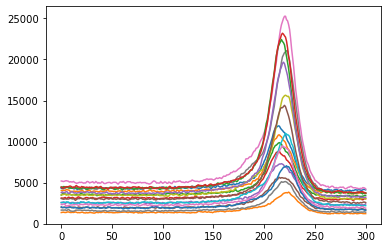

(19, 301)
(301, 19)


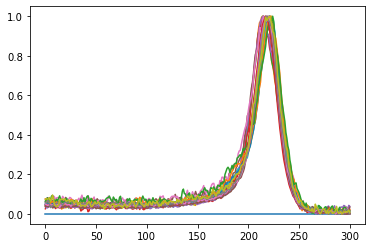

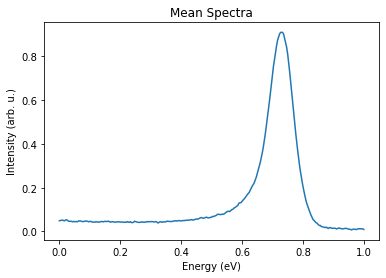

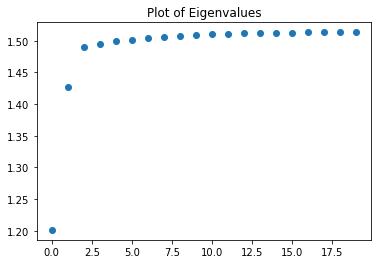

target = 0.95 of total data variance:  1.4376267785238954
Critical value:  2


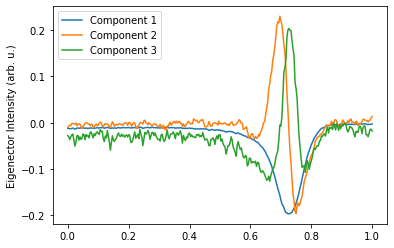

In [5]:
directory = "/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Stepped Heating 4-3-23/O Mixed"
masterdata = snapshots_from_dir(directory)
test = masterdata.data[1]
print(test.shape)
plot_all_spectra(masterdata)
oxygen = perform_pca_1D(masterdata)
get_pca_info(oxygen)


(161, 2)


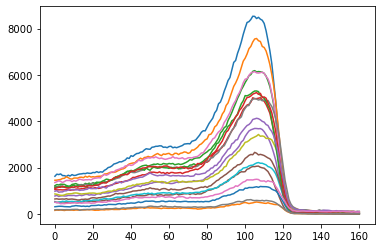

(19, 161)
(161, 19)


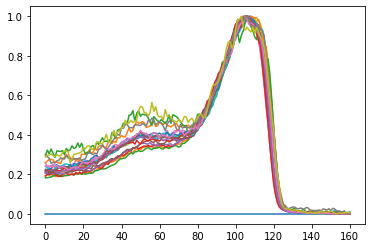

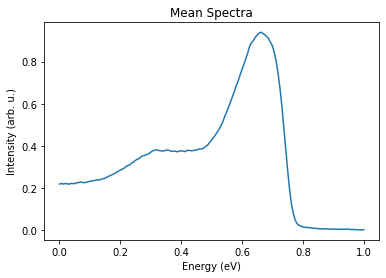

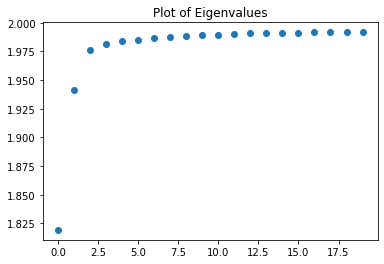

target = 0.99 of total data variance:  1.9718681683473274
Critical value:  2


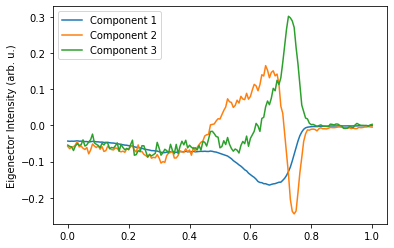

In [6]:
directory = "/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Stepped Heating 4-3-23/Valence Mixed"
masterdata = snapshots_from_dir(directory,align_snapshots=False)
test = masterdata.data[1]
print(test.shape)
plot_all_spectra(masterdata)
valence = perform_pca_1D(masterdata)
get_pca_info(valence,target_variance = .99,max_plotted=3)

specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
(19, 341)
(251, 19)


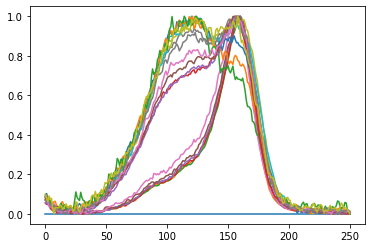

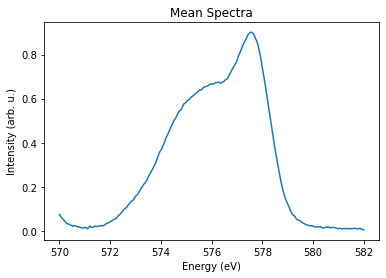

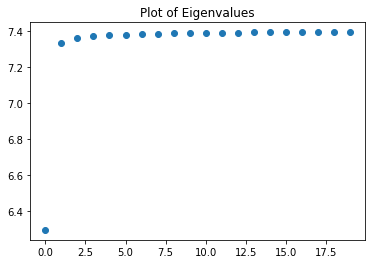

target = 0.995 of total data variance:  7.354770647603105
Critical value:  2


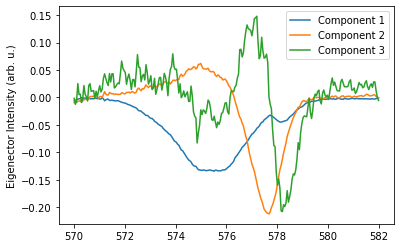

In [13]:
directory = "/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Stepped Heating 4-3-23/Cr Mixed"
masterdata = snapshots_from_dir(directory,align_snapshots=False,subtract_shirley=True)
chromium = perform_pca_1D(masterdata,energy_range = [570,582],trim_points=90,mean_centered=False)
get_pca_info(chromium,target_variance = .995, energy_range = [570,582], max_plotted=3)

(19, 481)
(361, 19)


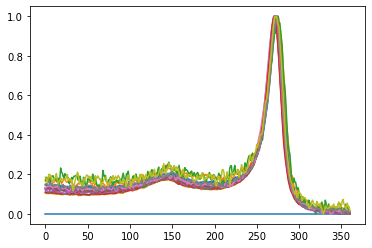

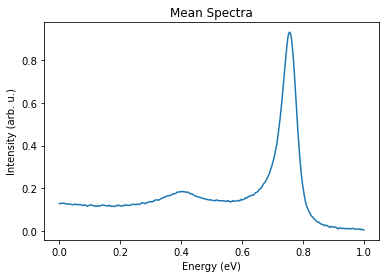

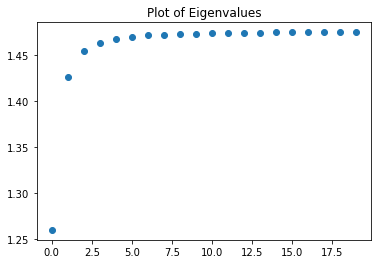

target = 0.99 of total data variance:  1.4600544359381777
Critical value:  3


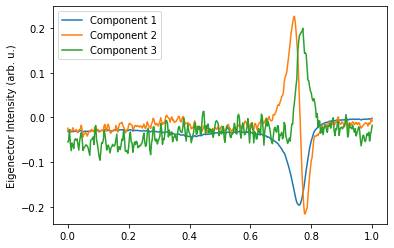

In [8]:
directory = "/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Stepped Heating 4-3-23/Ni Mixed"
masterdata = snapshots_from_dir(directory,align_snapshots=False)
nickel = perform_pca_1D(masterdata,trim_points=120)
get_pca_info(nickel,target_variance = .99, max_plotted=2)

The live heating data is not aligned so PCA won't return any meaningful results.   I need to register these curves on top of each other if I want to get meaningful results out of the live heating

In [9]:
live_heating = "/Users/apple/Sync/Research/Native Oxide work/Ni15Cr Live Heating 3-31-23"

masterdata = snapshots_from_dir(live_heating, align_snapshots=True)

ni_list = masterdata[masterdata.scantype == "Ni2p3/2"].copy()
cr_list = masterdata[masterdata.scantype == "Cr2p3/2"].copy()
valence_list = masterdata[masterdata.scantype == "Valence"].copy()
o_list = masterdata[masterdata.scantype == "O1s"].copy()

1.0
1.0
-0.2999999999999545
-0.2999999999999545
-0.2999999999999545
-0.2999999999999545
-12.0
-12.0
1.599999999999909
1.599999999999909
1.599999999999909
1.599999999999909
2.0
2.0
2.0
2.0
1.7999999999999545
1.7999999999999545
1.7999999999999545
1.7999999999999545
1.599999999999909
1.599999999999909
1.599999999999909
1.599999999999909
1.5
1.5
1.5
1.5
1.2000000000000455
1.2000000000000455
1.2000000000000455
1.2000000000000455
1.0
1.0
1.0
1.0
0.8999999999998636
0.8999999999998636
0.8999999999998636
0.8999999999998636
0.7999999999999545
0.7999999999999545
0.7999999999999545
0.7999999999999545
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.2999999999999545
0.2999999999999545
0.2999999999999545
0.2999999999999545
0.20000000000004547
0.20000000000004547
0.20000000000004547
0.20000000000004547
0.0
0.0
0.0
0.0
-0.10000000000013642
-0.10000000000013642
-0.10000000000013642
-0.10000000000013642
-0.2999999999999545
-0.2999999999999545
-0.2999999999999545
-0.2999999999999545
-0.40000000000009095
-0.400000000000

(44, 241)
(241, 44)


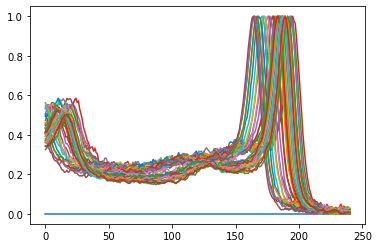

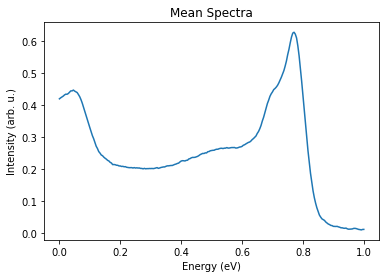

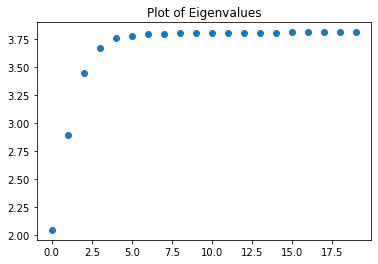

target = 0.95 of total data variance:  3.627898887835143
Critical value:  3


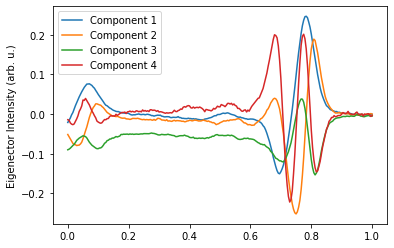

In [10]:
nickel_live = perform_pca_1D(ni_list)
get_pca_info(nickel_live,target_variance = .95, max_plotted=3)

(49, 131)
(131, 49)


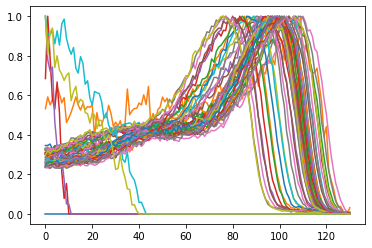

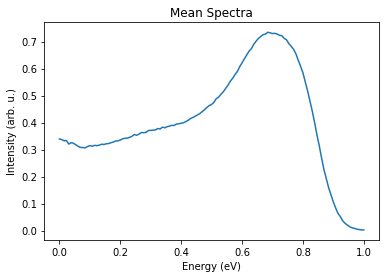

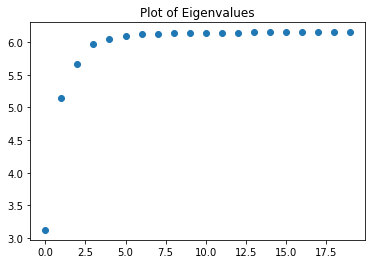

target = 0.95 of total data variance:  5.850096100910229
Critical value:  3


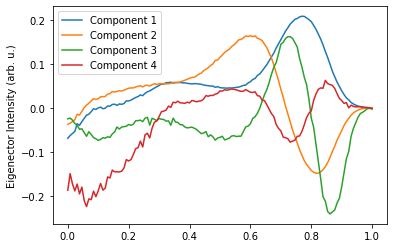

In [11]:
valence_live = perform_pca_1D(valence_list)
get_pca_info(valence_live)